In [1]:
import os
import glob
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from sklearn.utils import shuffle
import time
import cv2
import scipy
from PIL import Image
import matplotlib.gridspec as gridspec
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten
from keras.layers import Conv2D, Conv2DTranspose, Dropout
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import keras.backend as K
#from scipy.interpolate import spline
K.set_image_dim_ordering('tf')
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.layers import Input, merge
from keras.initializers import RandomNormal
K.set_image_dim_ordering('tf')
config = tf.ConfigProto()
config.gpu_options.allow_growth = True 
set_session(tf.Session(config=config))
from collections import deque

Using TensorFlow backend.


In [2]:
filenames = glob.glob('data/*.png')

print("Num_Images: ",len(filenames))

Num_Images:  21551


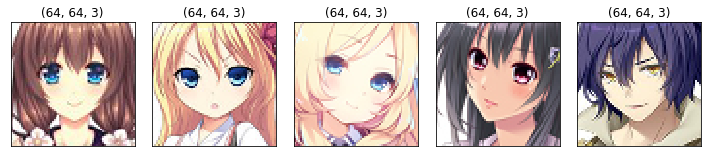

In [3]:
plt.figure(figsize=(10, 8))
for i in range(5):
    img = plt.imread(filenames[i], 0)
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(img.shape)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [4]:
# A function to normalize image pixels.
def norm_img(img):
    '''A function to Normalize Images.
    Input:
        img : Original image as numpy array.
    Output: Normailized Image as numpy array
    '''
    img = (img / 127.5) - 1
    return img

def denorm_img(img):
    '''A function to Denormailze, i.e. recreate image from normalized image
    Input:
        img : Normalized image as numpy array.
    Output: Original Image as numpy array
    '''
    img = (img + 1) * 127.5
    return img.astype(np.uint8) 

def sample_from_dataset(batch_size, image_shape, data_dir=None):
    '''Create a batch of image samples by sampling random images from a data directory.
    Resizes the image using image_shape and normalize the images.
    Input:
        batch_size : Sample size required
        image_size : Size that Image should be resized to
        data_dir : Path of directory where training images are placed.

    Output:
        sample : batch of processed images 
    '''
    sample_dim = (batch_size,) + image_shape
    sample = np.empty(sample_dim, dtype=np.float32)
    all_data_dirlist = list(glob.glob(data_dir))
    sample_imgs_paths = np.random.choice(all_data_dirlist,batch_size)
    for index,img_filename in enumerate(sample_imgs_paths):
        image = Image.open(img_filename)
        image = image.resize(image_shape[:-1])
        image = image.convert('RGB') 
        image = np.asarray(image)
        image = norm_img(image)
        sample[index,...] = image
    return sample

In [5]:
def gen_noise(batch_size, noise_shape):
    ''' Generates a numpy vector sampled from normal distribution of shape (batch_size,noise_shape)
    Input:
        batch_size : size of batch
        noise_shape: shape of noise vector, normally kept as 100 
    Output:a numpy vector sampled from normal distribution of shape (batch_size,noise_shape)     
    '''
    return np.random.normal(0, 1, size=(batch_size,)+noise_shape)

In [6]:
def get_gen_normal(noise_shape):
    ''' This function takes as input shape of the noise vector and creates the Keras generator    architecture.
    '''
    kernel_init = 'glorot_uniform'    
    gen_input = Input(shape = noise_shape) 
    
    # Transpose 2D conv layer 1. 
    generator = Conv2DTranspose(filters = 512, kernel_size = (4,4), strides = (1,1), padding = "valid", data_format = "channels_last", kernel_initializer = kernel_init)(gen_input)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Transpose 2D conv layer 2.
    generator = Conv2DTranspose(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Transpose 2D conv layer 3.
    generator = Conv2DTranspose(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Transpose 2D conv layer 4.
    generator = Conv2DTranspose(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # conv 2D layer 1.
    generator = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Final Transpose 2D conv layer 5 to generate final image. Filter size 3 for 3 image channel
    generator = Conv2DTranspose(filters = 3, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    
    # Tanh activation to get final normalized image
    generator = Activation('tanh')(generator)
    
    # defining the optimizer and compiling the generator model.
    gen_opt = Adam(lr=0.00015, beta_1=0.5)
    generator_model = Model(input = gen_input, output = generator)
    generator_model.compile(loss='binary_crossentropy', optimizer=gen_opt, metrics=['accuracy'])
    generator_model.summary()
    return generator_model

In [7]:
def get_disc_normal(image_shape=(64,64,3)):
    dropout_prob = 0.4
    kernel_init = 'glorot_uniform'
    dis_input = Input(shape = image_shape)
    
    # Conv layer 1:
    discriminator = Conv2D(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(dis_input)
    discriminator = LeakyReLU(0.2)(discriminator)
    # Conv layer 2:
    discriminator = Conv2D(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    # Conv layer 3:   
    discriminator = Conv2D(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    # Conv layer 4:
    discriminator = Conv2D(filters = 512, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)#discriminator = MaxPooling2D(pool_size=(2, 2))(discriminator)
    # Flatten
    discriminator = Flatten()(discriminator)
    # Dense Layer
    discriminator = Dense(1)(discriminator)
    # Sigmoid Activation
    discriminator = Activation('sigmoid')(discriminator)
    # Optimizer and Compiling model
    dis_opt = Adam(lr=0.0002, beta_1=0.5)
    discriminator_model = Model(input = dis_input, output = discriminator)
    discriminator_model.compile(loss='binary_crossentropy', optimizer=dis_opt, metrics=['accuracy'])
    discriminator_model.summary()
    return discriminator_model

In [8]:
!mkdir images

mkdir: images: File exists


In [9]:
# Shape of noise vector to be input to the Generator
noise_shape = (1,1,100)
# Number of steps for training. num_epochs = num_steps*batch_size/data_size
num_steps = 50000
# batch size for training.
batch_size = 64
# Location to save images and logs 
img_save_dir = "images"
# Image size to reshape to
image_shape = (64,64,3)
# Location of data directory
data_dir = "data/*.png"
# set up log and save directories
log_dir = img_save_dir
save_model_dir = img_save_dir

In [10]:
def save_img_batch(img_batch,img_save_dir):
    '''Takes as input a image batch and a img_save_dir and saves 16 images from the batch in a 4x4 grid in the img_save_dir
    '''
    plt.figure(figsize=(16,16))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(img_batch.shape[0],16,replace=False)
    for i in range(16):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = img_batch[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(img_save_dir,bbox_inches='tight',pad_inches=0)
    plt.show() 

In [11]:
discriminator = get_disc_normal(image_shape)
generator = get_gen_normal(noise_shape)

Instructions for updating:
Colocations handled automatically by placer.


/Users/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         524544    
__________

/Users/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [12]:
discriminator.trainable = False

# Optimizer for the GAN
opt = Adam(lr=0.00015, beta_1=0.5) #same as generator
# Input to the generator
gen_inp = Input(shape=noise_shape)

GAN_inp = generator(gen_inp)
GAN_opt = discriminator(GAN_inp)

# Final GAN
gan = Model(input = gen_inp, output = GAN_opt)
gan.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])

/Users/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`
  if sys.path[0] == '':


Begin step:  0


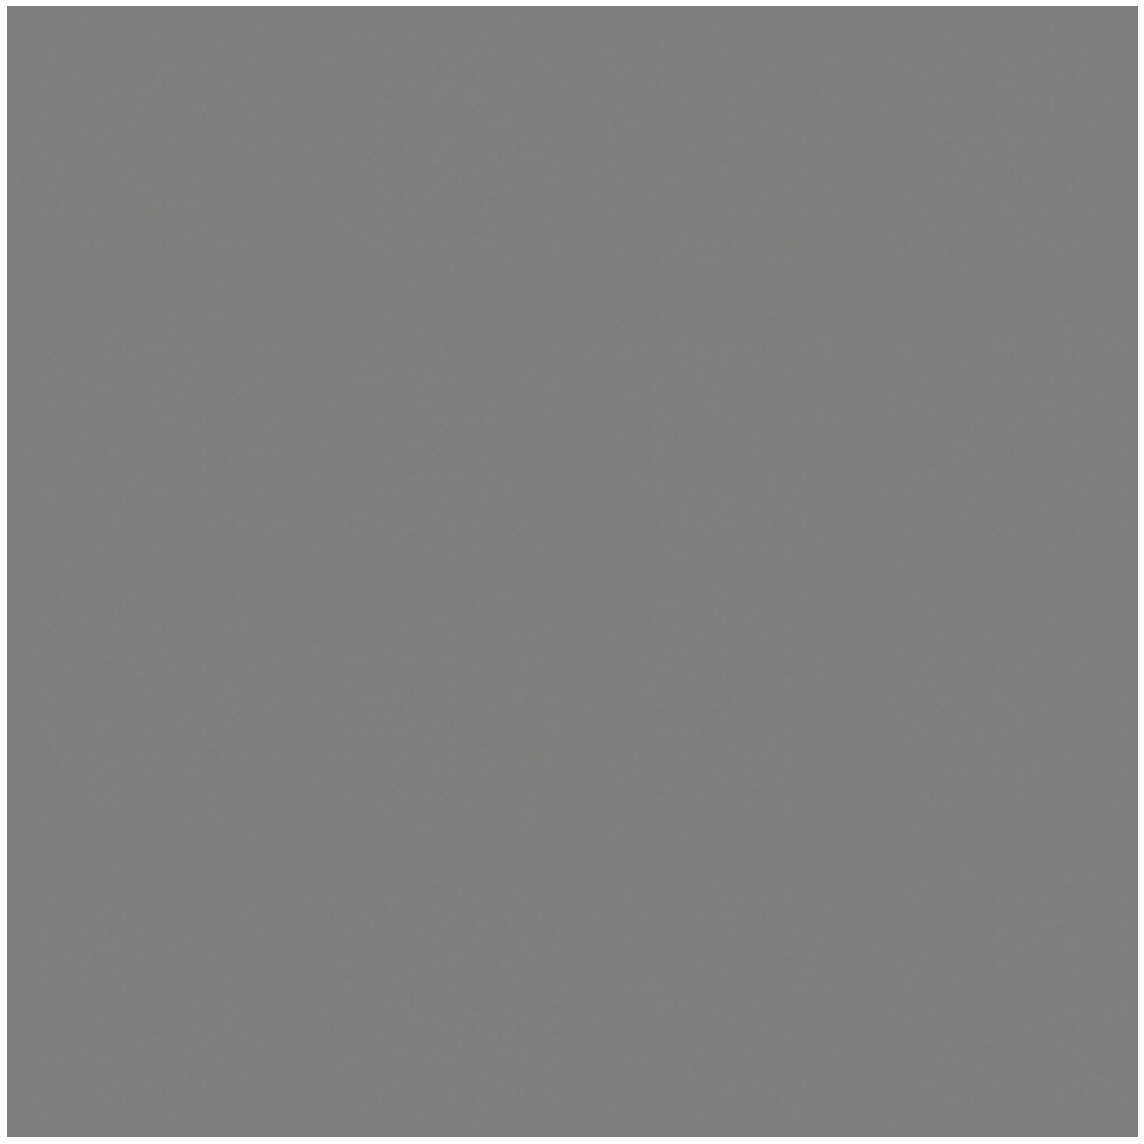

Instructions for updating:
Use tf.cast instead.
Disc: real loss: 1.104766 fake loss: 2.187299
GAN loss: 2.357179
Step 0 completed. Time took: 8 secs.
Begin step:  1
Disc: real loss: 0.972448 fake loss: 0.401468
GAN loss: 3.621054
Step 1 completed. Time took: 2 secs.
Begin step:  2
Disc: real loss: 1.011069 fake loss: 0.401076
GAN loss: 3.113695
Step 2 completed. Time took: 2 secs.
Begin step:  3
Disc: real loss: 0.694269 fake loss: 0.414117
GAN loss: 3.580277
Step 3 completed. Time took: 2 secs.
Begin step:  4
Disc: real loss: 0.681102 fake loss: 0.438065
GAN loss: 3.701082
Step 4 completed. Time took: 2 secs.
Begin step:  5
Disc: real loss: 0.630402 fake loss: 0.380040
GAN loss: 3.368291
Step 5 completed. Time took: 2 secs.
Begin step:  6
Disc: real loss: 0.428599 fake loss: 0.501816
GAN loss: 5.208063
Step 6 completed. Time took: 2 secs.
Begin step:  7
Disc: real loss: 0.660097 fake loss: 0.444132
GAN loss: 2.225091
Step 7 completed. Time took: 2 secs.
Begin step:  8
Disc: real loss:

Disc: real loss: 0.435604 fake loss: 0.442018
GAN loss: 2.973138
Step 67 completed. Time took: 2 secs.
Begin step:  68
Disc: real loss: 0.395708 fake loss: 0.420353
GAN loss: 1.187135
Step 68 completed. Time took: 2 secs.
Begin step:  69
Disc: real loss: 0.389854 fake loss: 0.515636
GAN loss: 3.537791
Step 69 completed. Time took: 2 secs.
Begin step:  70
Disc: real loss: 0.696891 fake loss: 0.446125
GAN loss: 2.957782
Step 70 completed. Time took: 2 secs.
Begin step:  71
Disc: real loss: 0.429460 fake loss: 0.354806
GAN loss: 2.251796
Step 71 completed. Time took: 2 secs.
Begin step:  72
Disc: real loss: 0.437828 fake loss: 0.537016
GAN loss: 5.267925
Step 72 completed. Time took: 2 secs.
Begin step:  73
Disc: real loss: 1.442208 fake loss: 1.401358
GAN loss: 5.578576
Step 73 completed. Time took: 2 secs.
Begin step:  74
Disc: real loss: 0.844775 fake loss: 0.441763
GAN loss: 2.958215
Step 74 completed. Time took: 2 secs.
Begin step:  75
Disc: real loss: 0.487155 fake loss: 0.788294
GA

In [ ]:
# Use a fixed noise vector to see how the GAN Images transition through time on a fixed noise. 
fixed_noise = gen_noise(16,noise_shape)

# To keep Track of losses
avg_disc_fake_loss = []
avg_disc_real_loss = []
avg_GAN_loss = []

# We will run for num_steps iterations
for step in range(num_steps): 
    tot_step = step
    print("Begin step: ", tot_step)
    # to keep track of time per step
    step_begin_time = time.time() 
    
    # sample a batch of normalized images from the dataset
    real_data_X = sample_from_dataset(batch_size, image_shape, data_dir=data_dir)
    
    # Genearate noise to send as input to the generator
    noise = gen_noise(batch_size,noise_shape)
    
    # Use generator to create(predict) images
    fake_data_X = generator.predict(noise)
    
    # Save predicted images from the generator every 10th step
    if (tot_step % 100) == 0:
        step_num = str(tot_step).zfill(4)
        save_img_batch(fake_data_X,img_save_dir+step_num+"_image.png")
    
    # Create the labels for real and fake data. We don't give exact ones and zeros but add a small amount of noise. This is an important GAN training trick
    real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
    fake_data_Y = np.random.random_sample(batch_size)*0.2
        
    # train the discriminator using data and labels

    discriminator.trainable = True
    generator.trainable = False

    # Training Discriminator seperately on real data
    dis_metrics_real = discriminator.train_on_batch(real_data_X,real_data_Y) 
    # training Discriminator seperately on fake data
    dis_metrics_fake = discriminator.train_on_batch(fake_data_X,fake_data_Y) 
    
    print("Disc: real loss: %f fake loss: %f" % (dis_metrics_real[0], dis_metrics_fake[0]))
    
    # Save the losses to plot later
    avg_disc_fake_loss.append(dis_metrics_fake[0])
    avg_disc_real_loss.append(dis_metrics_real[0])
    
    # Train the generator using a random vector of noise and its labels (1's with noise)
    generator.trainable = True
    discriminator.trainable = False

    GAN_X = gen_noise(batch_size,noise_shape)
    GAN_Y = real_data_Y
   
    gan_metrics = gan.train_on_batch(GAN_X,GAN_Y)
    print("GAN loss: %f" % (gan_metrics[0]))
    
    # Log results by opening a file in append mode
    text_file = open(log_dir+"\\training_log.txt", "a")
    text_file.write("Step: %d Disc: real loss: %f fake loss: %f GAN loss: %f\n" % (tot_step, dis_metrics_real[0], dis_metrics_fake[0],gan_metrics[0]))
    text_file.close()

    # save GAN loss to plot later
    avg_GAN_loss.append(gan_metrics[0])
            
    end_time = time.time()
    diff_time = int(end_time - step_begin_time)
    print("Step %d completed. Time took: %s secs." % (tot_step, diff_time))
    
    # save model at every 500 steps
    if ((tot_step+1) % 500) == 0:
        print("-----------------------------------------------------------------")
        print("Average Disc_fake loss: %f" % (np.mean(avg_disc_fake_loss))) 
        print("Average Disc_real loss: %f" % (np.mean(avg_disc_real_loss))) 
        print("Average GAN loss: %f" % (np.mean(avg_GAN_loss)))
        print("-----------------------------------------------------------------")
        discriminator.trainable = False
        generator.trainable = False
        # predict on fixed_noise
        fixed_noise_generate = generator.predict(noise)
        step_num = str(tot_step).zfill(4)
        save_img_batch(fixed_noise_generate,img_save_dir+step_num+"fixed_image.png")
        generator.save(save_model_dir+str(tot_step)+"_GENERATOR_weights_and_arch2.hdf5")
        discriminator.save(save_model_dir+str(tot_step)+"_DISCRIMINATOR_weights_and_arch2.hdf5")

In [ ]:
def generate_images(generator, save_dir):
    noise = gen_noise(batch_size,noise_shape)
    fake_data_X = generator.predict(noise)
    print("Displaying generated images")
    plt.figure(figsize=(16,16))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(fake_data_X.shape[0],16,replace=False)
    for i in range(16):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = fake_data_X[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(save_dir+str(time.time())+"_GENERATEDimage.png",bbox_inches='tight',pad_inches=0)
    plt.show()

generate_images(generator, img_save_dir)

In [ ]:
disc_real_loss = np.array(avg_disc_real_loss)
disc_fake_loss = np.array(avg_disc_fake_loss)
GAN_loss = np.array(avg_GAN_loss)

# Plot the losses vs training steps
plt.figure(figsize=(16,8))
plt.plot(range(0,num_steps), disc_real_loss, label="Discriminator Loss - Real")
plt.plot(range(0,num_steps), disc_fake_loss, label="Discriminator Loss - Fake")
plt.plot(range(0,num_steps), GAN_loss, label="Generator Loss")
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Loss')
plt.grid(True)
plt.show() 

In [ ]:
#Generating GIF from PNGs
import imageio
# create a list of PNGs
generated_images = [img_save_dir+str(x).zfill(4)+"_image.png" for x in range(0,num_steps,100)]

In [ ]:
images = []
for filename in generated_images:
    images.append(imageio.imread(filename))

imageio.mimsave(img_save_dir+'movie.gif', images) 

In [ ]:
from IPython.display import Image
with open("images/movie.gif",'rb') as f:
    display(Image(data=f.read(), format='png'))